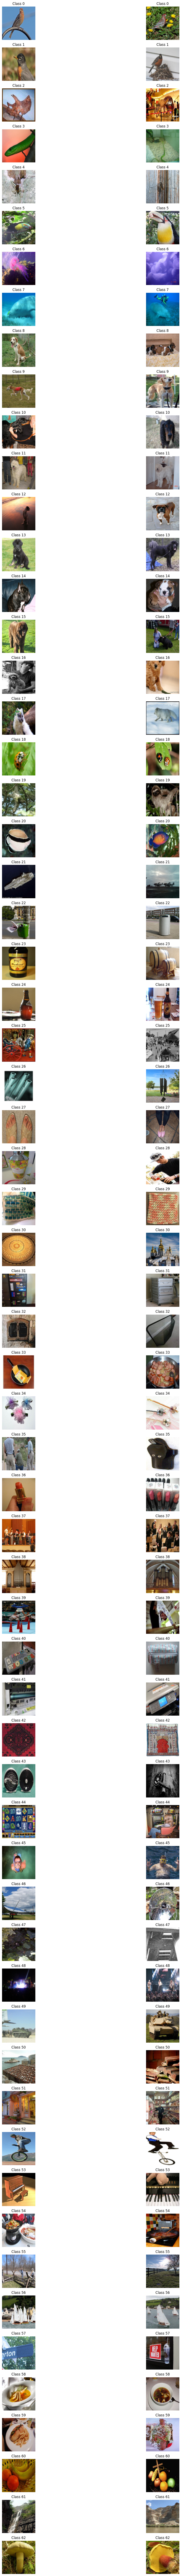

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the pickle file
file_path = "/home/ubuntu/Few_shot/MiniImagenet/miniImageNet_category_split_train_phase_train.pickle"

with open(file_path, 'rb') as f:
    data = pickle.load(f, encoding='latin1')

# Extract the images and labels
images = np.array(data['data'])
labels = np.array(data['labels'])

# Find the first 63 unique classes
unique_classes = np.unique(labels)[:63]

# Plot two images for each of the 63 classes
plt.figure(figsize=(20, 126))  # Adjust the figure size to fit all images

for i, cls in enumerate(unique_classes):
    class_indices = np.where(labels == cls)[0]
    # Plot the first two images of each class
    for j in range(2):
        plt.subplot(63, 2, i * 2 + j + 1)
        plt.imshow(images[class_indices[j]])
        plt.title(f"Class {cls}")
        plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
import pickle
import os

# Paths
input_file = '/home/ubuntu/Few_shot/few-shot-meta-baseline/train_features.pickle'
output_folder = '/home/ubuntu/Few_shot/train-gen_data'

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Load the input pickle file
with open(input_file, 'rb') as f:
    data = pickle.load(f)

# Assuming 'data' is a dictionary with keys 'features' and 'labels'
features = data['logits']
labels = data['labels']

# Save features and labels to the output folder
features_output_path = os.path.join(output_folder, 'features.pickle')
labels_output_path = os.path.join(output_folder, 'labels.pickle')

with open(features_output_path, 'wb') as f:
    pickle.dump(features, f)

with open(labels_output_path, 'wb') as f:
    pickle.dump(labels, f)

print(f"Features have been saved to {features_output_path} and labels have been saved to {labels_output_path}.")


Features have been saved to /home/ubuntu/Few_shot/train-gen_data/features.pickle and labels have been saved to /home/ubuntu/Few_shot/train-gen_data/labels.pickle.


In [8]:
import pickle

# Paths to the features and labels files
features_file = '/home/ubuntu/Few_shot/train-gen_data/features.pickle'
labels_file = '/home/ubuntu/Few_shot/train-gen_data/labels.pickle'

# Load the features from the pickle file
with open(features_file, 'rb') as f:
    features = pickle.load(f)

# Load the labels from the pickle file
with open(labels_file, 'rb') as f:
    labels = pickle.load(f)

# Print the shape of the features
print(f"The shape of the features is: {features.shape}")

# Print the shape of the labels
print(f"The shape of the labels is: {labels.shape}")


The shape of the features is: (38400, 512)
The shape of the labels is: (38400,)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.spatial import distance
from torch.autograd import Variable
import pickle
import clip
from torch.nn.functional import normalize
test_dic = {
    '80': [
        'The Dalmatian is a medium-sized dog breed known for its distinctive coat pattern of black spots on a white background.',
        'It has a muscular body, a slightly rounded head, and alert, expressive eyes.',
        'Dalmatians are known for their energetic and playful nature, making them popular as family pets and firehouse mascots.'
    ],
    '81': [
        'Nematodes are a diverse group of worms that can be found in various habitats, including soil, freshwater, and marine environments.',
        'They have a slender, unsegmented body with a tapered shape at both ends.',
        'Nematodes play important roles in ecosystems as decomposers, predators, and parasites.'
    ],
    '82': [
        'An ant is a small insect known for its organized social behavior and strong sense of colony cooperation.',
        'It has a segmented body with six legs and a pair of antennae on its head.',
        'Ants are highly adaptable and can be found in diverse habitats, forming intricate underground nests or building mounds.'
    ],
    '83': [
        'The black-footed ferret is a small carnivorous mammal and one of the most endangered species in North America.',
        'It has a slender body, a long neck, and a distinctive black mask on its face.',
        'Black-footed ferrets are known for their agility and hunting skills, primarily preying on prairie dogs.'
    ],
    '84': [
        'The king crab is a large crustacean known for its impressive size and spiky appearance.',
        'It has a hard exoskeleton, long legs, and large pincers used for feeding and defense.',
        'King crabs are prized for their meat and are popular in seafood cuisine.'
    ],
    '85': [
        'The lion is a majestic big cat known for its golden mane and powerful build.',
        'It has a large, muscular body, a rounded head, and a roar that can be heard from a considerable distance.',
        'Lions are apex predators and live in social groups known as prides.'
    ],
    '86': [
        'A vase is a decorative container usually made of glass, ceramic, or porcelain.',
        'It has a cylindrical or bulbous shape with a narrow neck and is used for holding flowers or as a standalone decorative piece.',
        'Vases come in various sizes, colors, and designs, adding beauty and elegance to interior spaces.'
    ],
    '87': [
        'The golden retriever is a friendly and intelligent dog breed with a dense, water-repellent coat.',
        'It has a sturdy body, a broad head, and a wagging tail that showcases its joyful nature.',
        'Golden retrievers are known for their loyalty and versatility, excelling as family pets, guide dogs, and search-and-rescue companions.'
    ],
    '88': [
        'A mixing bowl is a kitchen utensil used for combining ingredients during food preparation.',
        'It has a rounded or cylindrical shape with a wide opening and a flat base.',
        'Mixing bowls come in various sizes and materials, such as stainless steel or ceramic, and are essential for baking and cooking.'
    ],
        '89': [
        'The Malamute is a large and powerful dog breed known for its strength and endurance.',
        'It has a sturdy body, a thick double coat, and erect ears.',
        'Malamutes are sled dogs and have a friendly and sociable temperament.'
    ],
    '90': [
        'The African Hunting Dog, also known as the African Wild Dog or Painted Wolf, is a highly social and skilled predator.',
        'It has a lean body, large rounded ears, and a unique coat pattern with patches of black, white, and tan.',
        'African Hunting Dogs live in packs and are known for their cooperative hunting style and impressive stamina.'
    ],
    '91': [
        'A cuirass is a piece of armor that protects the torso and consists of a breastplate and a backplate.',
        'It has a flat and rigid structure, providing protection to the chest and abdomen.',
        'Cuirasses were commonly used by ancient warriors and knights in combat.'
    ],
    '92': [
        'A bookshop, also known as a bookstore, is a retail establishment where books are sold.',
        'It typically has shelves or racks filled with books of various genres and subjects.',
        'Bookshops often provide a cozy and inviting atmosphere for browsing and discovering new literary treasures.'
    ],
    '93': [
        'A crate is a sturdy container made of wood, plastic, or metal, used for storing or transporting goods.',
        'It has a rectangular shape with solid walls and often features handles or latches for ease of handling.',
        'Crates are versatile and commonly used in logistics, storage, and pet training.'
    ],
    '94': [
        'An hourglass is a timekeeping device consisting of two glass bulbs connected by a narrow neck, with sand or granules flowing from one bulb to the other.',
        'It has a distinct hourglass shape, with the upper and lower bulbs symmetrically aligned.',
        'Hourglasses were historically used to measure time and are often associated with concepts of passing time and urgency.'
    ],
    '95': [
        'The electric guitar is a stringed musical instrument that uses electromagnetic pickups to convert string vibrations into electrical signals.',
        'It has a solid or semi-hollow body, a neck with frets, and multiple pickups and controls for tone and volume adjustment.',
        'Electric guitars are widely used in various music genres, offering a wide range of sounds and styles.'
    ],
    '96': [
        'A trifle is a layered dessert typically made with sponge cake, custard, fruit, and whipped cream.',
        'It is usually presented in a glass bowl or dish, showcasing its visually appealing layers.',
        'Trifles are popular desserts for special occasions and gatherings, offering a delightful combination of textures and flavors.'
    ],
    '97': [
        'A school bus is a type of vehicle designed to transport students to and from school.',
        'It has a large, rectangular body with multiple rows of seats, safety features, and distinctive yellow paint.',
        'School buses are essential for safe and reliable transportation of students.'
    ],
    '98': [
        'A theater curtain, also known as a stage curtain or drape, is a large piece of fabric used to conceal or reveal the stage during theatrical performances.',
        'It can be made of various materials, such as velvet or heavy fabric, and is often adorned with decorative elements.',
        'Theater curtains add drama and anticipation, enhancing the visual experience of the audience.'
    ],
    '99': [
        'A scoreboard is an electronic or manual display used to keep track of scores or other important information during sports or competitive events.',
        'It typically consists of a series of panels or digits that can be updated to show numbers or text.',
        'Scoreboards are essential for providing real-time information to participants and spectators.'
    ]
}

enco_ddict ={}
test_enco_ddict ={}
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

for key in test_dic.keys():
    list_temp=[]
    for dis in test_dic[key]:
        tt = clip.tokenize([dis]).cuda()
        text_features = model.encode_text(tt).float()
        list_temp.append(text_features.cpu().detach().numpy())
    #print(len(list_temp))
    test_enco_ddict[int(key)-80] = torch.tensor(np.mean(np.array(list_temp),axis=0))


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [10]:
test_enco_ddict[1].shape

torch.Size([1, 512])

In [12]:
import torch
import torch.nn as nn

# Define the Generator model class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(512, 8192),
            nn.BatchNorm1d(8192),
            nn.LeakyReLU(0.2),
            nn.Linear(8192,4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

# Load the generator model
generator = Generator().to('cuda')

# Load the pre-trained weights
generator.load_state_dict(torch.load("/home/ubuntu/Few_shot/w-1-text-tired-gen-model.pth"))

# Set the model to evaluation mode
generator.eval()

# Example input tensor (512-dimensional input)
input_feature = test_enco_ddict[1].to('cuda')

# Generate features using the generator
with torch.no_grad():
    generated_feature = generator(input_feature)

# Print the generated feature
print("Generated Feature Shape:", generated_feature.shape)
#print("Generated Feature:", generated_feature)


Generated Feature Shape: torch.Size([1, 512])


/tmp/ipykernel_5750/3551272521.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/home/ubuntu/Few_shot/w-1-text-tired-gen-model.pth"